In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import missingno as msno

from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 20
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["axes.unicode_minus"] = False

# data_loc = "D:/data/h-and-m-personalized-fashion-recommendations/"
data_loc = "G:/내 드라이브/프로젝트/Kaggle_H&M/data/h-and-m-personalized-fashion-recommendations/"

In [2]:
def row_show(x=None):
    pd.set_option("max_rows", x)
    
def col_show(x=None):
    pd.set_option("max_columns",x)

os.listdir(data_loc)

['images',
 'articles.csv',
 'customers.csv',
 'sample_submission.csv',
 'transactions_train.csv']

# 0.Data Load
---

In [3]:
df_customers = pd.read_csv(data_loc+"customers.csv", encoding="utf-8")
# df_articles = pd.read_csv(data_loc+"articles.csv", encoding="utf-8")
# df_submissions = pd.read_csv(data_loc+"sample_submission.csv", encoding="utf-8")
# df_transactions_train = pd.read_csv(data_loc+"transactions_train.csv", encoding="utf-8")

# 1.Data Look Up
---

## 1.1.Basic Information
---

In [4]:
df_customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [5]:
## look up columns in df_cutomers

for col in df_customers.columns:
    unq = df_customers[col].unique()
    print(f"{col}:\t{unq if len(unq) < 10 else '*** Lots Of Values ***'}\n")

customer_id:	*** Lots Of Values ***

FN:	[nan  1.]

Active:	[nan  1.]

club_member_status:	['ACTIVE' nan 'PRE-CREATE' 'LEFT CLUB']

fashion_news_frequency:	['NONE' 'Regularly' nan 'Monthly' 'None']

age:	*** Lots Of Values ***

postal_code:	*** Lots Of Values ***



**Relation between `FN` column and `Active` column**

- First, Replacement NaN value in "FN" and "Active"
- Second, Check the Spearman Correlation Coefficent

*RESULT : There is a high correlation between the two.*

In [6]:
temp_FN = df_customers["FN"].fillna(0.)
temp_cus = df_customers["Active"].fillna(0.)

import statsmodels

**Relation between `ACTIVE` column and the `ACITVE` record in `club_member_status`**

- First, sum `Active` column (we already replacement Nan -> 0.)
- Second, sum `club_member_status` if it has `ACTIVE` value

*RESULT : They don't have any realation.*

In [7]:
print(df_customers["Active"].sum())
print((df_customers["club_member_status"]=="ACTIVE").sum())

464404.0
1272491


**What mean columns in `df_customers`**

- `customer_id` : Customer's Unique ID

- `FN : <span style="color:magenta"> I DON'T KNOW WHAT IT MEANS </span>

- `Active`: <span style="color:magenta"> I DON'T KNOW WHAT IT MEANS </span>

- `club_member_status`: The status that customers sign in members (It has 3 status - ACTIVE, PRE-CREATE, LEFT CLUB +NAN)

- `fashion_news_frequency`: The qualitative cycle to read fashion news

- `age`: Customer's age

- `postal_code`:


In [8]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [9]:
df_customers.describe()

,FN,Active,age
count,476930.0,464404.0,1.356119e+06
mean,1.0,1.0,3.638696e+01
std,0.0,0.0,1.431363e+01
min,1.0,1.0,1.600000e+01
25%,1.0,1.0,2.400000e+01
50%,1.0,1.0,3.200000e+01
75%,1.0,1.0,4.900000e+01
max,1.0,1.0,9.900000e+01


continuous columns: ['FN', 'Active', 'age']
categorical columns: ['customer_id', 'club_member_status', 'fashion_news_frequency', 'postal_code']


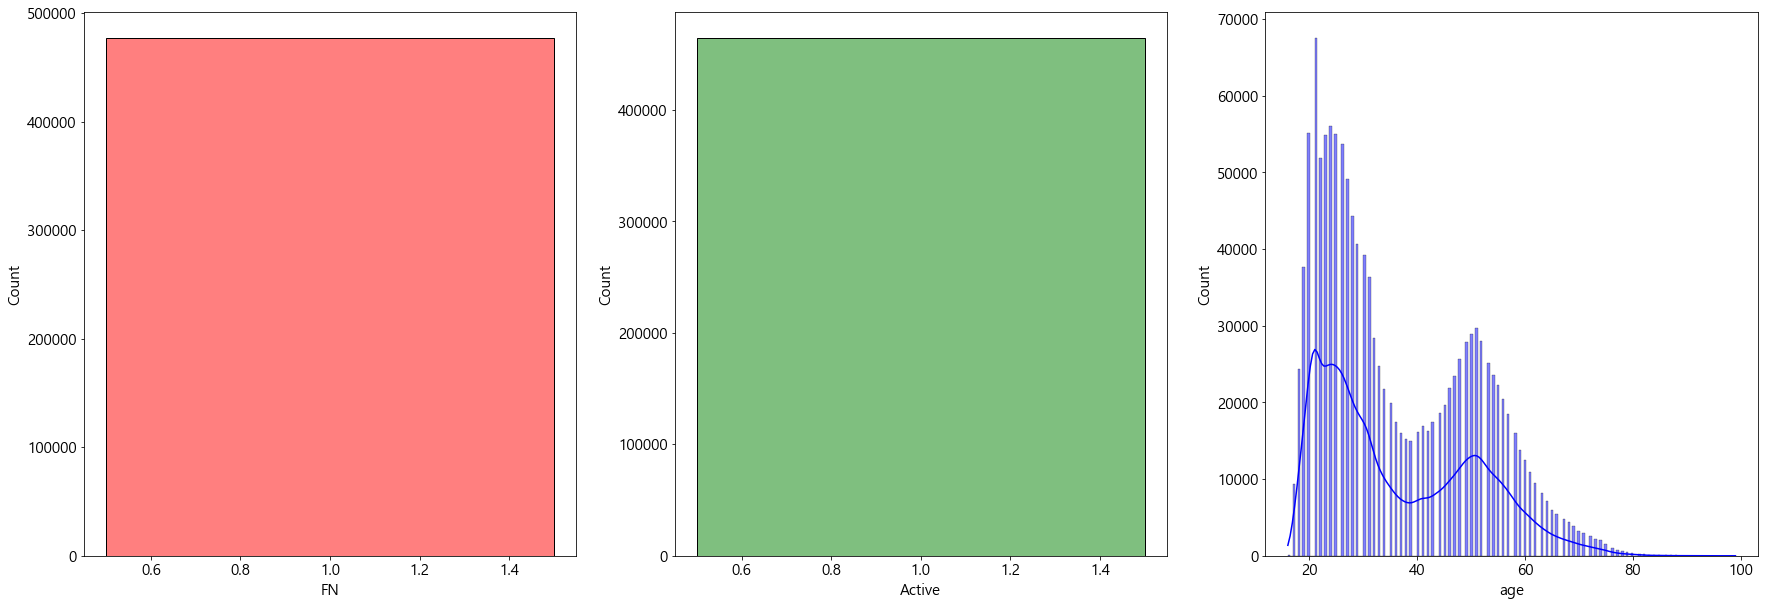

In [10]:
cont_cols, cate_cols =[], []
for col in df_customers.columns:
    if df_customers[col].dtype=="object": cate_cols.append(col)
    else: cont_cols.append(col)
    
print(f"continuous columns: {cont_cols}")
print(f"categorical columns: {cate_cols}")

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(1,3)
for i,color in zip(range(0,3),["red","green","blue"]):
    sns.histplot(ax=ax[i], data=df_customers[cont_cols[i]], kde=True, color=color)
    
plt.show()

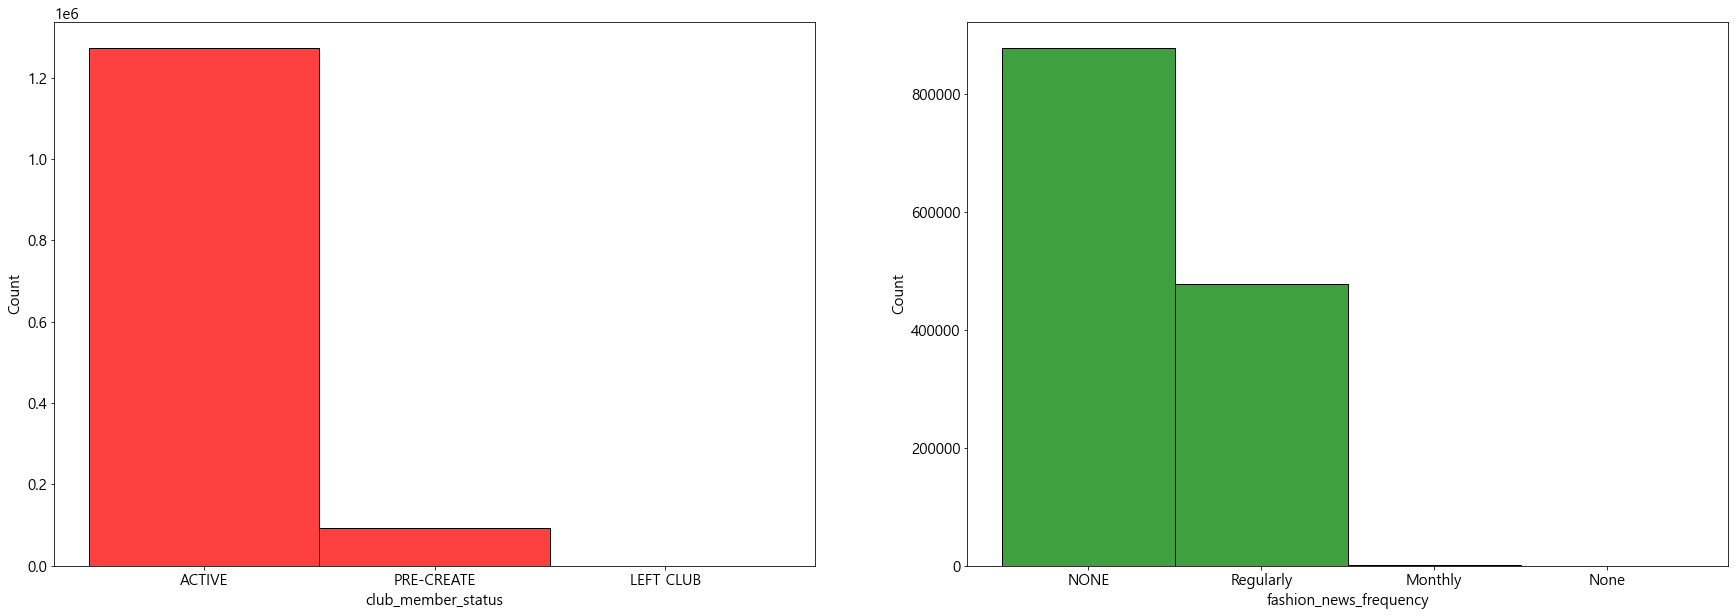

=== frequency of categorical columns ===
club_member_status Frequency: 
	ACTIVE: 1272491
	nan: 0
	PRE-CREATE: 92960
	LEFT CLUB: 467
fashion_news_frequency Frequency: 
	NONE: 877711
	Regularly: 477416
	nan: 0
	Monthly: 842
	None: 2


In [11]:
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(1,2)
for i,color in zip(range(0,4),[0, "red","green","blue"]):
    if i==0 or i==3: continue
    sns.histplot(ax=ax[i-1], data=df_customers[cate_cols[i]], color=color)
    
plt.show()

print("=== frequency of categorical columns ===")
for i in range(0,4):
    if i==0 or i==3: continue
    print(f"{cate_cols[i]} Frequency: ")
    for record in df_customers[cate_cols[i]].unique():
        print(f"\t{record}: {sum(df_customers[cate_cols[i]]==record)}")
        

## 1.2.Missing Value
---

 ==== missing value report ====
	 Missing value count 
customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16009
age                        15861
postal_code                    0
dtype: int64
	 Missing value ratio 
customer_id               0.000000
FN                        0.652378
Active                    0.661508
club_member_status        0.004418
fashion_news_frequency    0.011669
age                       0.011561
postal_code               0.000000
dtype: float64


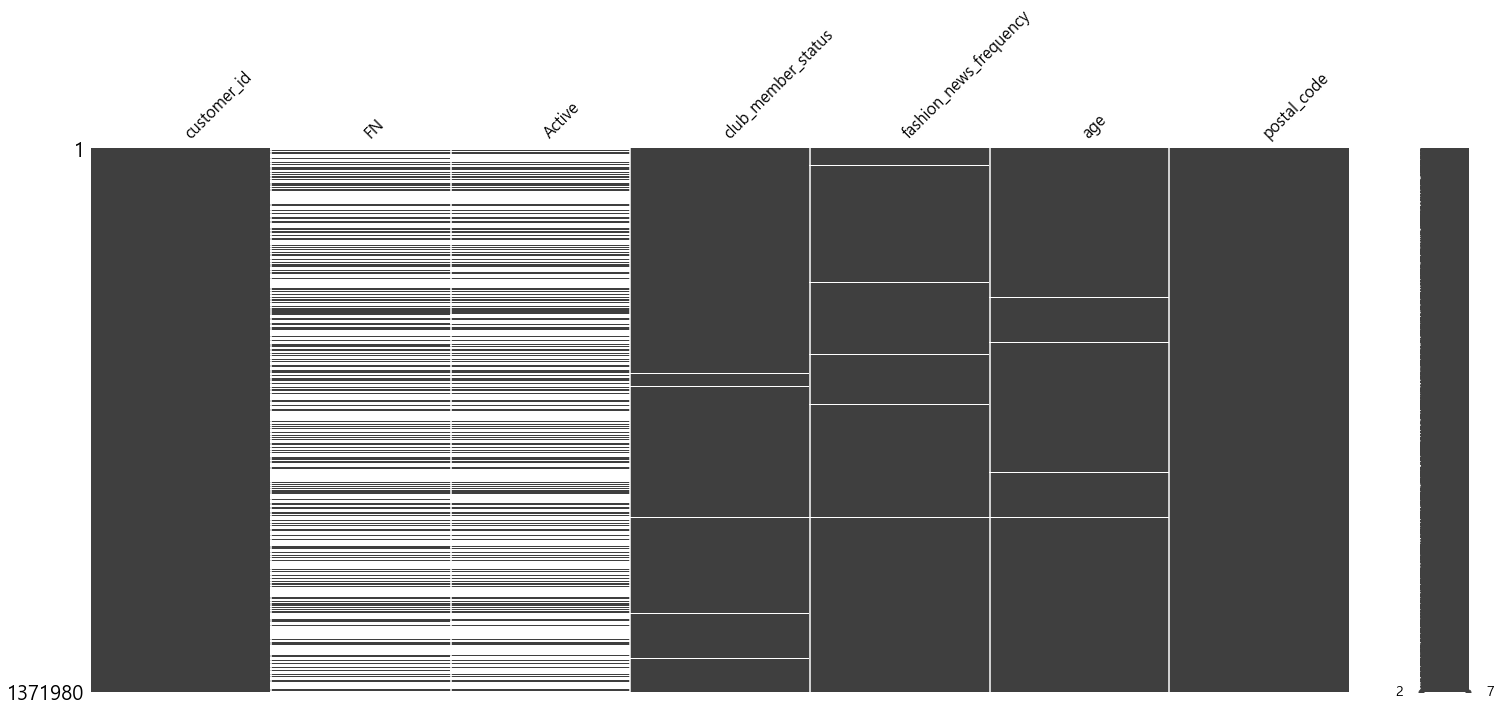

In [12]:
def missing_value_report(df):
    print(" ==== missing value report ====")
    print(f"\t Missing value count \n{df.isna().sum(axis=0)}")
    print(f"\t Missing value ratio \n{(df.isna().sum(axis=0))/len(df['customer_id'])}")
    msno.matrix(df)
    plt.show

missing_value_report(df_customers)

In [13]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [14]:
df_customers.describe()

,FN,Active,age
count,476930.0,464404.0,1.356119e+06
mean,1.0,1.0,3.638696e+01
std,0.0,0.0,1.431363e+01
min,1.0,1.0,1.600000e+01
25%,1.0,1.0,2.400000e+01
50%,1.0,1.0,3.200000e+01
75%,1.0,1.0,4.900000e+01
max,1.0,1.0,9.900000e+01


continuous columns: ['FN', 'Active', 'age']
categorical columns: ['customer_id', 'club_member_status', 'fashion_news_frequency', 'postal_code']


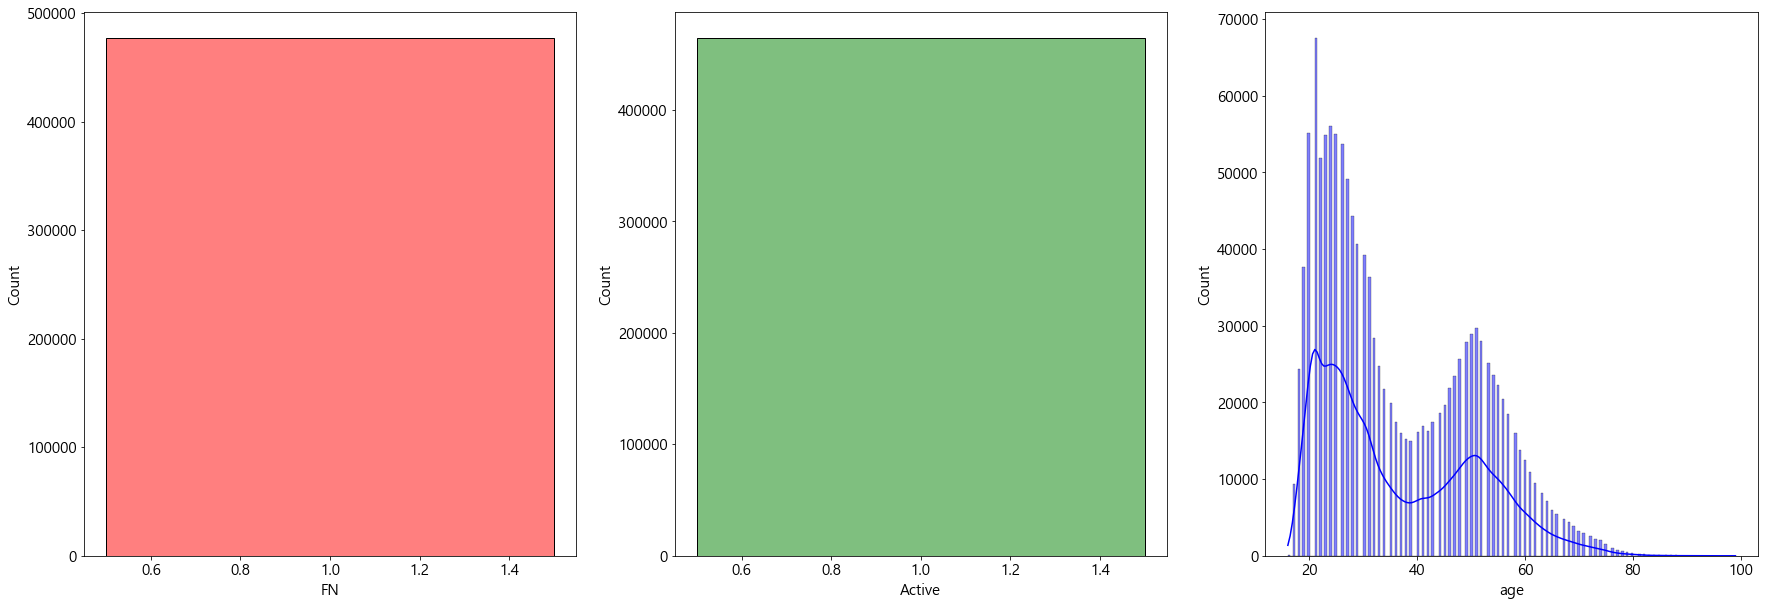

In [15]:
cont_cols, cate_cols =[], []
for col in df_customers.columns:
    if df_customers[col].dtype=="object": cate_cols.append(col)
    else: cont_cols.append(col)
    
print(f"continuous columns: {cont_cols}")
print(f"categorical columns: {cate_cols}")

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (30,10)
fig, ax = plt.subplots(1,3)
for i,color in zip(range(0,3),["red","green","blue"]):
    sns.histplot(ax=ax[i], data=df_customers[cont_cols[i]], kde=True, color=color)
    
plt.show()